#Normalization

In [ ]:
# prepare data for lstm
import numpy as np
import pandas as pd
from pandas import read_excel
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

#Dengan outlier (1961 Data)
#dataset = read_excel('/content/drive/MyDrive/Excel-Tugas Akhir/15 Menit Split Waktu Okupansi (2).xlsx')

#Tanpa outlier (2059 data)
dataset = read_excel("/content/drive/MyDrive/Excel-Tugas Akhir/Try-15MenitFeatureFreeOutlier.xlsx")

skip_cols = []

# Pisahkan fitur dan target
X = dataset.iloc[:, :-1]
y = dataset.iloc[:, -1]

# Tentukan kolom yang akan dinormalisasi (selain skip_cols)
cols_to_scale = [col for col in X.columns if col not in skip_cols]

# Normalisasi hanya pada kolom yang dipilih
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled_part = scaler_X.fit_transform(X[cols_to_scale])
X_scaled_part_df = pd.DataFrame(X_scaled_part, columns=cols_to_scale)

# Gabungkan kembali dengan kolom skip yang tidak dinormalisasi
X_scaled_final = pd.concat([X_scaled_part_df, X[skip_cols].reset_index(drop=True)], axis=1)
X_scaled_final = X_scaled_final[X.columns]  # Kembalikan ke urutan kolom semula

# Normalisasi target
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Gabungkan fitur dan target jadi satu array/dataframe jika perlu
scaled = np.hstack((X_scaled_final.values, y_scaled))
scaled_df = pd.DataFrame(scaled, columns=dataset.columns)
selected_columns = dataset.columns[[17,25]]
dataset_cleared = scaled_df[selected_columns]
# Cek hasil
print(dataset_cleared.head())

     Energi  Rerata Okupansi
0  0.139488              0.0
1  0.093172              0.0
2  0.100937              0.0
3  0.106216              0.0
4  0.103708              0.0


#Split Data (Time Series)

In [ ]:
import numpy as np
from keras.models import Sequential

# Pisahkan fitur dan target
X_scaled = dataset_cleared.iloc[:, :-1].values  # fitur
y_scaled = dataset_cleared.iloc[:, -1].values   # target


# Fungsi membuat urutan sequence time series
def create_sequences(X, y, time_steps=8):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Parameter timestep
time_steps = 8

# Buat data berurutan
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

# Split menjadi train dan test (contoh)
split = int(0.7 * len(X_seq))
train_X, test_X = X_seq[:split], X_seq[split:]
train_y, test_y = y_seq[:split], y_seq[split:]

# Print hasil split data
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1435, 8, 1) (1435,) (615, 8, 1) (615,)


#Modelling

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError, MeanSquaredError
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

#Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',       # bisa juga 'loss' kalau tidak pakai validation split
    patience=20,              # jumlah epoch menunggu sebelum stop
    restore_best_weights=True  # ambil bobot terbaik, bukan bobot terakhir
)


# Bangun model LSTM
model = Sequential()
model.add(LSTM(units=128, activation='selu', input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
#model.add(Dropout(0.2))
model.add(LSTM(units=128, activation='selu'))
#model.add(Dropout(0.2))
#model.add(LSTM(units=128, activation='tanh'))
#model.add(Dropout(0.1))
model.add(Dense(1))  # Output 1 nilai (regresi)

# Compile model menggunakan MAE sebagai loss function utama, dan tambahkan MSE sebagai metrik
model.compile(optimizer=Adam(learning_rate=0.001), loss='mae', metrics=['mae', 'mse'])

# Latih model
history = model.fit(train_X, train_y, epochs=100, batch_size=8, validation_data=(test_X, test_y), callbacks=[early_stop], verbose=1)

# Prediksi
y_pred = model.predict(test_X)

# Evaluasi
mae_value = mean_absolute_error(test_y, y_pred)
#mae_value = mean_absolute_error(test_y, y_pred.reshape(-1))
mse_value = mean_squared_error(test_y, y_pred)
#mse_value = mean_squared_error(test_y, y_pred.reshape(-1))

print(f"Test MAE: {mae_value:.5f}")
print(f"Test MSE: {mse_value:.5f}")
model.summary()

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - loss: 0.1385 - mae: 0.1385 - mse: 0.0420 - val_loss: 0.1308 - val_mae: 0.1308 - val_mse: 0.0358
Epoch 2/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1266 - mae: 0.1266 - mse: 0.0381 - val_loss: 0.1145 - val_mae: 0.1145 - val_mse: 0.0247
Epoch 3/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.1195 - mae: 0.1195 - mse: 0.0318 - val_loss: 0.1151 - val_mae: 0.1151 - val_mse: 0.0262
Epoch 4/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 0.1250 - mae: 0.1250 - mse: 0.0338 - val_loss: 0.1181 - val_mae: 0.1181 - val_mse: 0.0302
Epoch 5/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1185 - mae: 0.1185 - mse: 0.0334 - val_loss: 0.1140 - val_mae: 0.1140 - val_mse: 0.0279
Epoch 6/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.1210 - mae: 0.1210 - mse: 0.0344 - val_loss: 0.1113 - val_mae: 0.1113 - val_mse: 0.0255
Epoch 7/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.1258 - mae: 0.1258 - mse: 0.0345 - v

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 8, 128)         │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 594,821 (2.27 MB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 396,548 (1.51 MB)

#Loss Function Graph

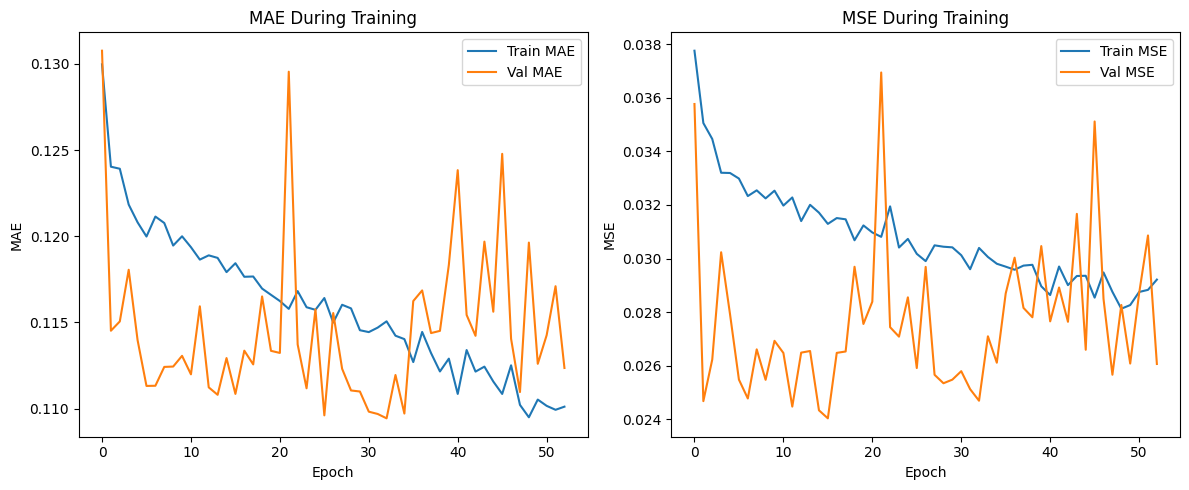

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# MAE
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE During Training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# MSE
plt.subplot(1, 2, 2)
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Val MSE')
plt.title('MSE During Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


#Prediksi

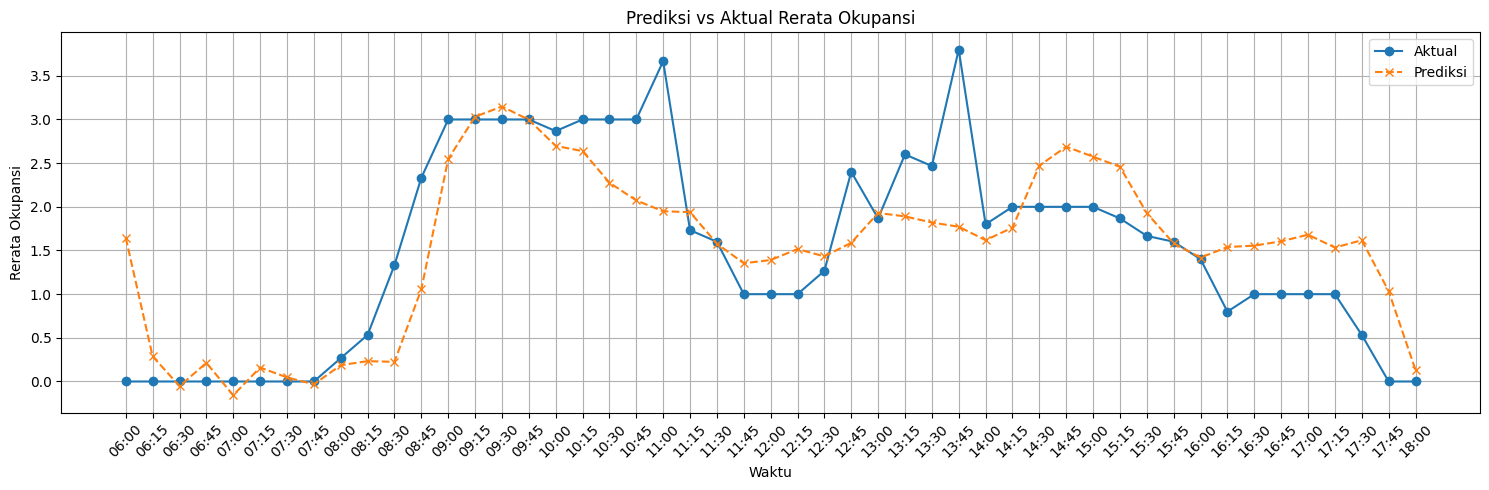

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ambil kolom waktu dari data asli (pastikan index sesuai dengan test_y)
tanggal_cols = dataset[['Hari', 'Tanggal', 'Bulan', 'Jam', 'Menit']].iloc[-len(test_y):].copy()

# Buat kolom datetime lengkap
tanggal_cols['TanggalLengkap'] = pd.to_datetime(
    tanggal_cols['Tanggal'].astype(str) + '-' +
    tanggal_cols['Bulan'].astype(str) + '-2025',
    dayfirst=True
)

# Gabungkan tanggal dan waktu ke format datetime
tanggal_cols['Datetime'] = tanggal_cols['TanggalLengkap'] + pd.to_timedelta(
    tanggal_cols['Jam'], unit='h'
) + pd.to_timedelta(tanggal_cols['Menit'], unit='m')

# Kolom baru hanya untuk waktu (jam:menit) dalam format string
tanggal_cols['Waktu'] = tanggal_cols['Datetime'].dt.strftime('%H:%M')

# Transformasi balik prediksi dan aktual
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
test_y_inv = scaler_y.inverse_transform(test_y.reshape(-1, 1)).flatten()

# Pembulatan hasil prediksi
#y_pred_inv = np.ceil(y_pred_inv).astype(int)

# Buat DataFrame untuk plot
plot_df = pd.DataFrame({
    'Waktu': tanggal_cols['Waktu'],
    'Datetime': tanggal_cols['Datetime'],
    'Aktual': test_y_inv,
    'Prediksi': y_pred_inv
})

# Filter data untuk tanggal yang ingin diprediksi
# Pilihan tanggal: Thurs10Apr, Mon14Apr, Tues15Apr, Wed16Apr, Thurs17Apr, Fri18Apr, Mon21Apr, Tues22Apr, Thurs24Apr, Fri25Apr, Mon28Apr, Fri2Mei
start_time = pd.to_datetime('2025-04-18 06:00')
end_time = pd.to_datetime('2025-04-18 18:00')
filtered_df = plot_df[(plot_df['Datetime'] >= start_time) & (plot_df['Datetime'] <= end_time)]

# Plot dengan sumbu x berupa waktu saja
plt.figure(figsize=(15, 5))
plt.plot(filtered_df['Waktu'], filtered_df['Aktual'], label='Aktual', marker='o')
plt.plot(filtered_df['Waktu'], filtered_df['Prediksi'], label='Prediksi', marker='x',linestyle='--')
plt.title('Prediksi vs Aktual Rerata Okupansi')
plt.xlabel('Waktu')
plt.ylabel('Rerata Okupansi')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#Error Calculation

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import statistics

# Fungsi MAPE
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Fungsi evaluasi
def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mse)
    avg = statistics.mean(y_true)
    mbe = np.mean(y_true - y_pred)
    nmbe = (mbe / avg) * 100
    cvrmse = (rmse / avg) * 100
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    r2 = corr ** 2
    return [mse, mae, rmse, cvrmse, r2, mbe, nmbe]

# Prediksi
y_train_pred = model.predict(train_X).reshape(-1)
y_test_pred = model.predict(test_X).reshape(-1)
y_train_true = train_y.reshape(-1)
y_test_true = test_y.reshape(-1)

# Evaluasi
train_metrics = evaluate_metrics(y_train_true, y_train_pred)
test_metrics = evaluate_metrics(y_test_true, y_test_pred)

# Tabel DataFrame
metric_names = ['MSE', 'MAE', 'RMSE', 'CV-RMSE', 'R^2', 'MBE', 'NMBE']
df_metrics = pd.DataFrame({
    'Metrik': metric_names,
    'Train': [f"{val:.5f}" for val in train_metrics],
    'Test': [f"{val:.5f}" for val in test_metrics]
})

# Tampilkan
print(df_metrics.to_string(index=False))


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 Metrik     Train     Test
    MSE   0.02803  0.02469
    MAE   0.11359  0.10944
   RMSE   0.16743  0.15714
CV-RMSE 103.14267 81.46825
    R^2   0.32337  0.34918
    MBE   0.02810  0.03373
   NMBE  17.31227 17.48556


#Prediksi 5 Grafik

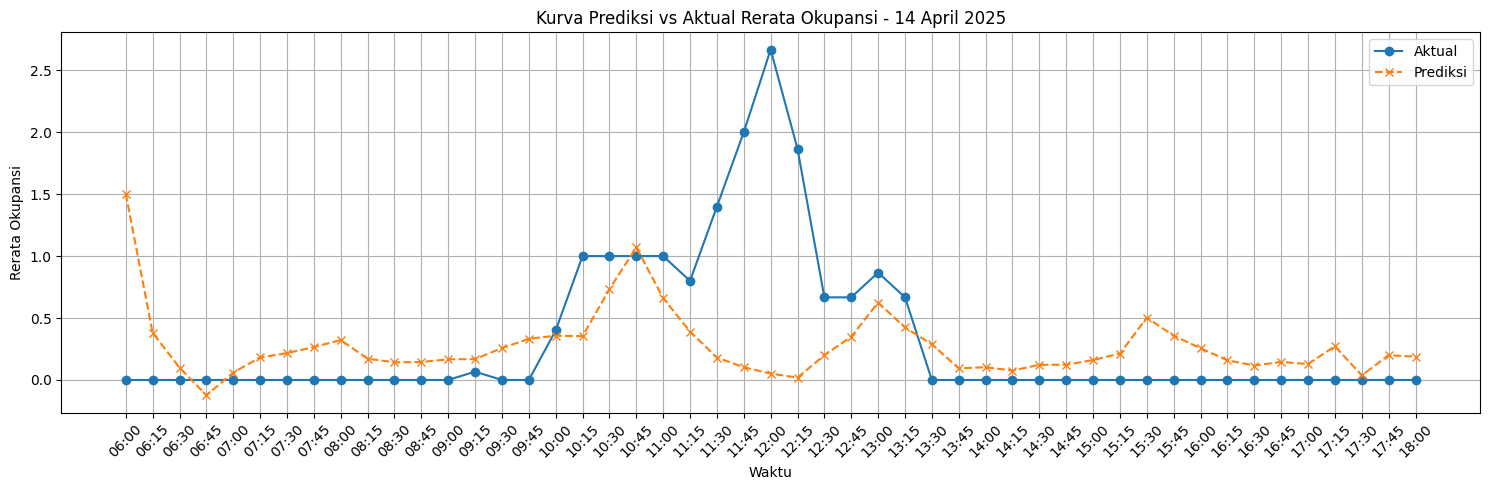

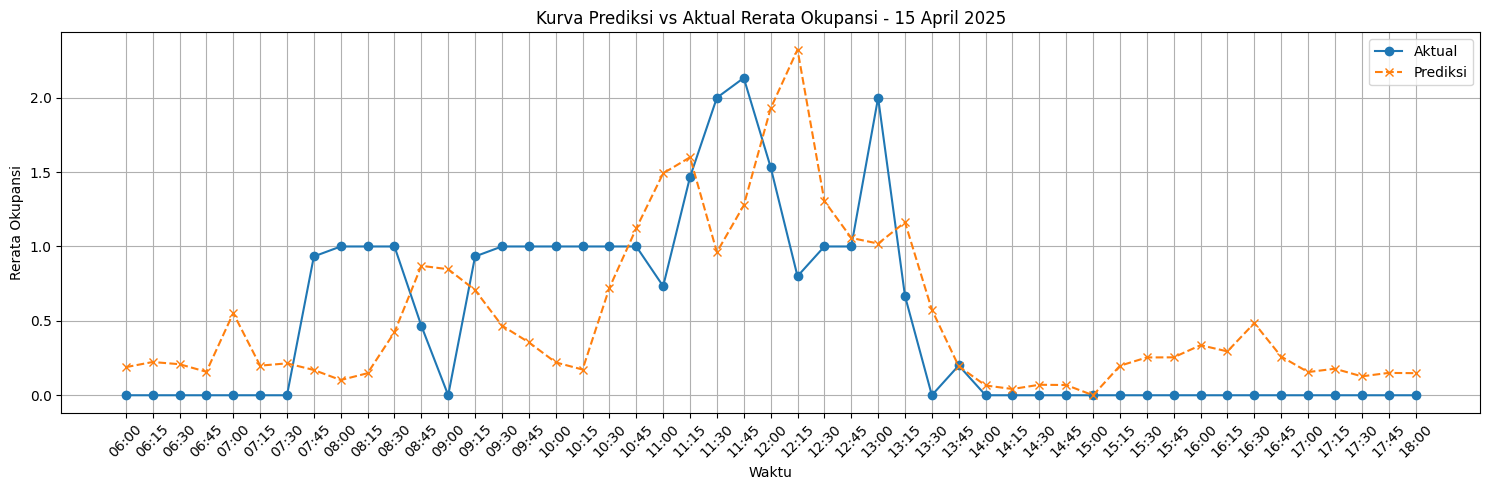

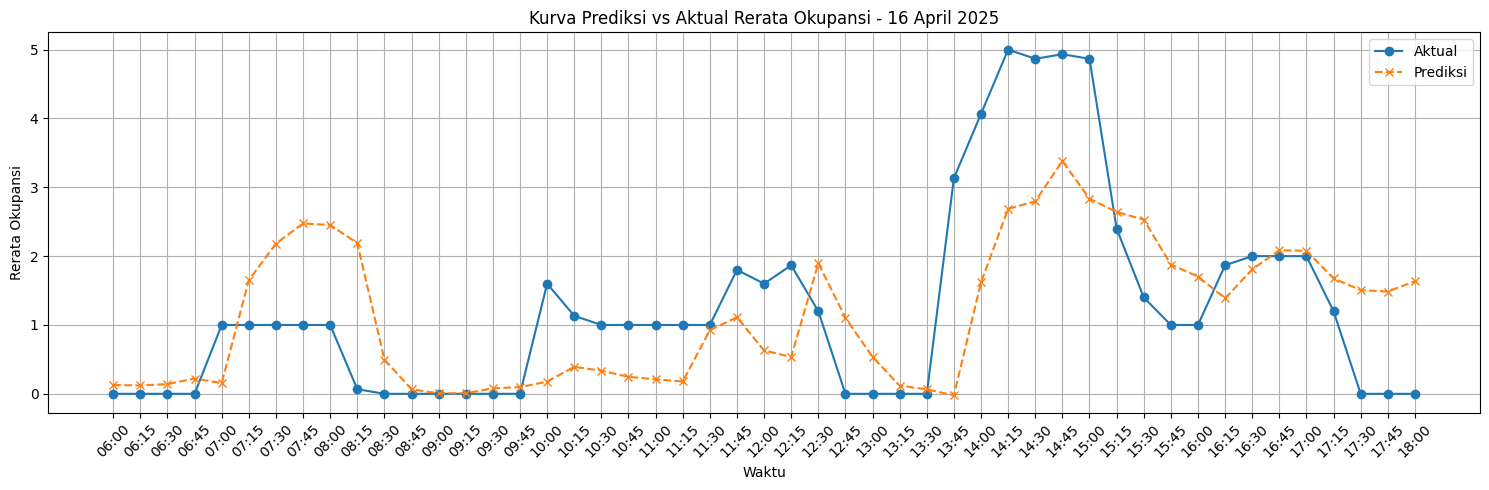

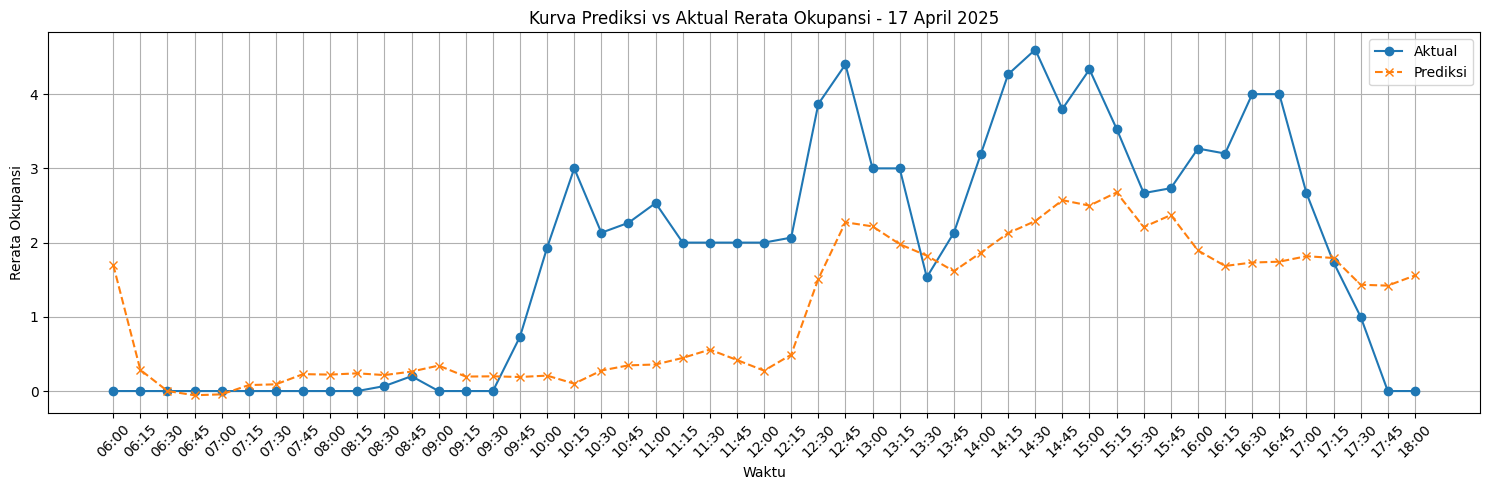

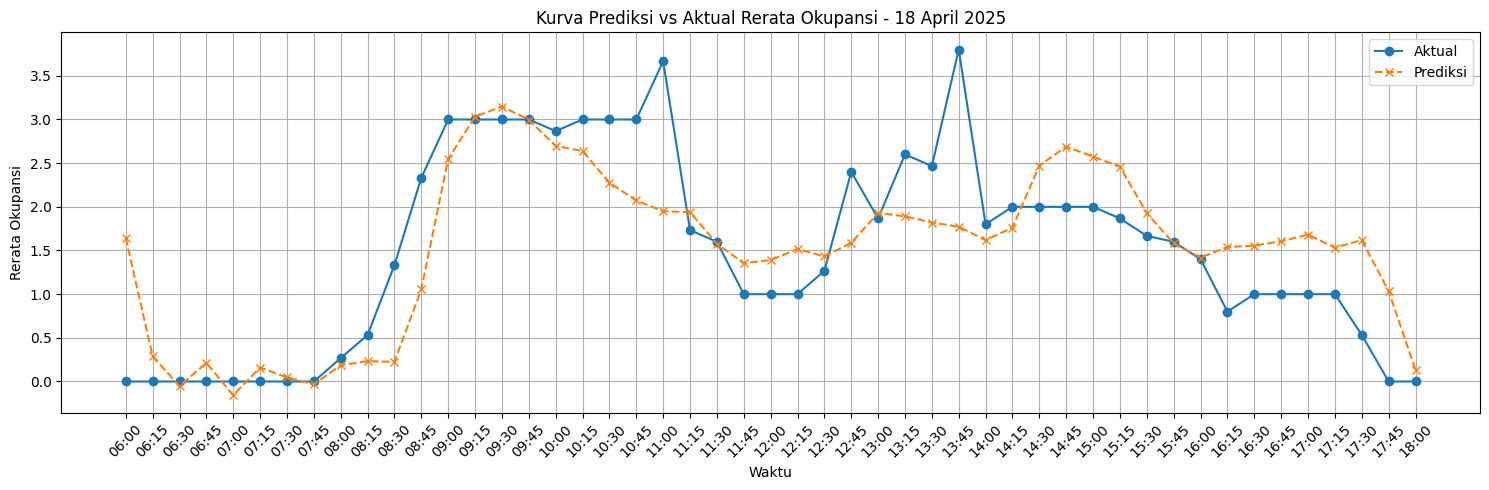

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Ambil kolom waktu dari data asli
tanggal_cols = dataset[['Hari', 'Tanggal', 'Bulan', 'Jam', 'Menit']].iloc[-len(test_y):].copy()

# Buat kolom datetime lengkap
tanggal_cols['TanggalLengkap'] = pd.to_datetime(
    tanggal_cols['Tanggal'].astype(str) + '-' +
    tanggal_cols['Bulan'].astype(str) + '-2025',
    dayfirst=True
)

# Gabungkan tanggal dan waktu ke format datetime
tanggal_cols['Datetime'] = tanggal_cols['TanggalLengkap'] + pd.to_timedelta(
    tanggal_cols['Jam'], unit='h'
) + pd.to_timedelta(tanggal_cols['Menit'], unit='m')

# Kolom baru hanya untuk waktu (jam:menit)
tanggal_cols['Waktu'] = tanggal_cols['Datetime'].dt.strftime('%H:%M')

# Transformasi balik prediksi dan aktual
y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()
test_y_inv = scaler_y.inverse_transform(test_y.reshape(-1, 1)).flatten()

# Buat DataFrame utama untuk plotting
plot_df = pd.DataFrame({
    'Waktu': tanggal_cols['Waktu'],
    'Datetime': tanggal_cols['Datetime'],
    'Tanggal': tanggal_cols['TanggalLengkap'].dt.date,
    'Aktual': test_y_inv,
    'Prediksi': y_pred_inv
})

# Daftar 5 tanggal yang ingin dipetakan (pastikan tanggalnya ada di dataset)
# Pilihan tanggal: Thurs10Apr, Mon14Apr, Tues15Apr, Wed16Apr, Thurs17Apr, Fri18Apr, Mon21Apr, Tues22Apr, Thurs24Apr, Fri25Apr, Mon28Apr, Fri2Mei
tanggal_list = [
    pd.to_datetime('2025-04-14').date(),
    pd.to_datetime('2025-04-15').date(),
    pd.to_datetime('2025-04-16').date(),
    pd.to_datetime('2025-04-17').date(),
    pd.to_datetime('2025-04-18').date()
]

# Plot untuk masing-masing tanggal
for tanggal in tanggal_list:
    start_time = pd.to_datetime(f"{tanggal} 06:00")
    end_time = pd.to_datetime(f"{tanggal} 18:00")

    filtered_df = plot_df[(plot_df['Datetime'] >= start_time) & (plot_df['Datetime'] <= end_time)]

    if not filtered_df.empty:
        plt.figure(figsize=(15, 5))
        plt.plot(filtered_df['Waktu'], filtered_df['Aktual'], label='Aktual', marker='o')
        plt.plot(filtered_df['Waktu'], filtered_df['Prediksi'], label='Prediksi', marker='x', linestyle='--')
        plt.title(f'Kurva Prediksi vs Aktual Rerata Okupansi - {tanggal.strftime("%d %B %Y")}')
        plt.xlabel('Waktu')
        plt.ylabel('Rerata Okupansi')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Tidak ada data untuk tanggal {tanggal}")


#Grid Search

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import itertools

# --------------------
# Parameter grid
# --------------------
layer_options = [1, 2]
unit_options = [16, 32,64]
dropout_options = [0.0, 0.1,0.2]
time_steps_list = [1, 2,4,6,8]
learning_rates = [0.001]
batch_size = 8
epochs = 100

# --------------------
# Simpan hasil tuning
# --------------------
results = []

# --------------------
# Loop semua kombinasi
# --------------------
for layers, units, dropout, time_steps, lr in itertools.product(layer_options, unit_options, dropout_options, time_steps_list, learning_rates):

    # Build model
    model = Sequential()
    model.add(LSTM(units, activation='tanh', return_sequences=(layers > 1), input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))

    if layers == 2:
        model.add(LSTM(units * 2, activation='tanh'))
        model.add(Dropout(dropout))

    model.add(Dense(1))
    model.compile(loss='mae', optimizer=Adam(learning_rate=lr))

    # Early Stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Training
    model.fit(train_X, train_y, epochs=epochs, batch_size=batch_size, validation_split=0.3,
              callbacks=[early_stop], verbose=1)

    # Predict and inverse transform
    y_train_pred = model.predict(train_X).flatten()
    y_test_pred = model.predict(test_X).flatten()

    y_train_pred_inv = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1)).flatten()
    train_y_inv = scaler_y.inverse_transform(train_y.reshape(-1, 1)).flatten()

    y_test_pred_inv = scaler_y.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
    test_y_inv = scaler_y.inverse_transform(test_y.reshape(-1, 1)).flatten()

    # Evaluasi metrik
    def evaluate(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        rmse = sqrt(mse)
        avg = np.mean(y_true)
        cvrmse = (rmse / avg) * 100
        mbe = np.mean(y_true - y_pred)
        nmbe = (mbe / avg) * 100
        r2 = np.corrcoef(y_true, y_pred)[0, 1] ** 2
        return mse, mae, rmse, cvrmse, r2, mbe, nmbe

    train_metrics = evaluate(train_y_inv, y_train_pred_inv)
    test_metrics = evaluate(test_y_inv, y_test_pred_inv)

    results.append({
        'layers': layers,
        'units': units,
        'dropout': dropout,
        'time_steps': time_steps,
        'lr': lr,
        'mse_train': train_metrics[0],
        'mae_train': train_metrics[1],
        'rmse_train': train_metrics[2],
        'cvrmse_train': train_metrics[3],
        'r2_train': train_metrics[4],
        'mbe_train': train_metrics[5],
        'nmbe_train': train_metrics[6],
        'mse_test': test_metrics[0],
        'mae_test': test_metrics[1],
        'rmse_test': test_metrics[2],
        'cvrmse_test': test_metrics[3],
        'r2_test': test_metrics[4],
        'mbe_test': test_metrics[5],
        'nmbe_test': test_metrics[6],
    })

# --------------------
# Simpan ke Excel
# --------------------
df = pd.DataFrame(results)
df.to_excel('Try-GridSearch-rev3.xlsx', index=False)
from google.colab import files
files.download('Try-GridSearch-rev3.xlsx')
print("Hasil tuning disimpan ke 'hasil_tuning_lstm.xlsx'")



Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1372 - val_loss: 0.1759
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1284 - val_loss: 0.1753
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1204 - val_loss: 0.1804
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1009 - val_loss: 0.1766
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1125 - val_loss: 0.1783
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1056 - val_loss: 0.1750
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1093 - val_loss: 0.1642
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1032 - val_loss: 0.1632
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0987 - val_loss: 0.1709
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0990 - val_loss: 0.1688
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1084 - val_loss: 0.1666
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1344 - val_loss: 0.1702
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1150 - val_loss: 0.1715
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1066 - val_loss: 0.1709
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1039 - val_loss: 0.1678
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1055 - val_loss: 0.1671
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1058 - val_loss: 0.1745
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1116 - val_loss: 0.1631
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1057 - val_loss: 0.1633
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0992 - val_loss: 0.1626
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1021 - val_loss: 0.1656
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1036 - val_loss: 0.1624
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1438 - val_loss: 0.1797
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1222 - val_loss: 0.1759
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1152 - val_loss: 0.1755
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1121 - val_loss: 0.1767
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1179 - val_loss: 0.1815
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1026 - val_loss: 0.1734
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1041 - val_loss: 0.1719
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1015 - val_loss: 0.1707
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1070 - val_loss: 0.1728
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1014 - val_loss: 0.1701
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0993 - val_loss: 0.1658
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1410 - val_loss: 0.1784
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1186 - val_loss: 0.1752
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1201 - val_loss: 0.1808
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1037 - val_loss: 0.1851
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1023 - val_loss: 0.1699
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1072 - val_loss: 0.1736
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1058 - val_loss: 0.1704
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1024 - val_loss: 0.1710
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1031 - val_loss: 0.1695
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1032 - val_loss: 0.1691
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1000 - val_loss: 0.1785
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1388 - val_loss: 0.1835
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1254 - val_loss: 0.1871
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1166 - val_loss: 0.1768
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1092 - val_loss: 0.1761
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1061 - val_loss: 0.1756
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1046 - val_loss: 0.1724
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1087 - val_loss: 0.1673
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0976 - val_loss: 0.1686
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1091 - val_loss: 0.1739
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1094 - val_loss: 0.1730
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1028 - val_loss: 0.1688
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1345 - val_loss: 0.1748
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1202 - val_loss: 0.1749
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1170 - val_loss: 0.1731
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1132 - val_loss: 0.1674
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1143 - val_loss: 0.1670
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1044 - val_loss: 0.1601
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1157 - val_loss: 0.1636
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1114 - val_loss: 0.1636
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1074 - val_loss: 0.1621
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1043 - val_loss: 0.1609
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1054 - val_loss: 0.1586
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1245 - val_loss: 0.1794
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1159 - val_loss: 0.1717
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1075 - val_loss: 0.1786
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1193 - val_loss: 0.1721
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1099 - val_loss: 0.1750
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1039 - val_loss: 0.1738
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1030 - val_loss: 0.1620
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1043 - val_loss: 0.1747
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1011 - val_loss: 0.1663
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0974 - val_loss: 0.1671
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1072 - val_loss: 0.1667
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.1380 - val_loss: 0.1759
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1230 - val_loss: 0.1788
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1143 - val_loss: 0.1724
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1087 - val_loss: 0.1746
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1141 - val_loss: 0.1791
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1128 - val_loss: 0.1729
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1054 - val_loss: 0.1702
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1038 - val_loss: 0.1676
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1059 - val_loss: 0.1629
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1001 - val_loss: 0.1724
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1090 - val_loss: 0.1781
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1497 - val_loss: 0.1697
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1234 - val_loss: 0.1662
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1194 - val_loss: 0.1665
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1136 - val_loss: 0.1632
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1137 - val_loss: 0.1622
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1116 - val_loss: 0.1638
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0995 - val_loss: 0.1634
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0998 - val_loss: 0.1582
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1012 - val_loss: 0.1612
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0972 - val_loss: 0.1697
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1089 - val_loss: 0.1660
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1479 - val_loss: 0.1796
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1150 - val_loss: 0.1764
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1201 - val_loss: 0.1736
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1028 - val_loss: 0.1700
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1048 - val_loss: 0.1695
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1022 - val_loss: 0.1689
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1102 - val_loss: 0.1801
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1039 - val_loss: 0.1686
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0965 - val_loss: 0.1717
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1018 - val_loss: 0.1660
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1093 - val_loss: 0.1653
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1446 - val_loss: 0.1766
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1350 - val_loss: 0.1752
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1213 - val_loss: 0.1758
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1172 - val_loss: 0.1730
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1122 - val_loss: 0.1818
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1078 - val_loss: 0.1735
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1136 - val_loss: 0.1737
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1144 - val_loss: 0.1792
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0993 - val_loss: 0.1729
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1035 - val_loss: 0.1738
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1042 - val_loss: 0.1802
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1455 - val_loss: 0.1775
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1309 - val_loss: 0.1780
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1172 - val_loss: 0.1774
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1122 - val_loss: 0.1700
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1107 - val_loss: 0.1676
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1080 - val_loss: 0.1692
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1076 - val_loss: 0.1687
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1055 - val_loss: 0.1668
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1044 - val_loss: 0.1753
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1051 - val_loss: 0.1678
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1078 - val_loss: 0.1706
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1603 - val_loss: 0.1799
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1420 - val_loss: 0.1795
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1244 - val_loss: 0.1771
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1306 - val_loss: 0.1750
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1242 - val_loss: 0.1725
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1082 - val_loss: 0.1778
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1148 - val_loss: 0.1739
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1187 - val_loss: 0.1705
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1010 - val_loss: 0.1688
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1142 - val_loss: 0.1783
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1090 - val_loss: 0.1703
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1507 - val_loss: 0.1709
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1269 - val_loss: 0.1739
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1183 - val_loss: 0.1688
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1073 - val_loss: 0.1655
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1082 - val_loss: 0.1673
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1142 - val_loss: 0.1690
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1089 - val_loss: 0.1641
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1111 - val_loss: 0.1708
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1079 - val_loss: 0.1675
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1078 - val_loss: 0.1631
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1024 - val_loss: 0.1681
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1352 - val_loss: 0.1779
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1213 - val_loss: 0.1734
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1183 - val_loss: 0.1725
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1141 - val_loss: 0.1703
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1062 - val_loss: 0.1736
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1078 - val_loss: 0.1763
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1098 - val_loss: 0.1699
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1013 - val_loss: 0.1759
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1059 - val_loss: 0.1780
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1121 - val_loss: 0.1691
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1078 - val_loss: 0.1745
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1251 - val_loss: 0.1680
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1141 - val_loss: 0.1632
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1089 - val_loss: 0.1653
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1085 - val_loss: 0.1663
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1096 - val_loss: 0.1638
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0999 - val_loss: 0.1682
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1053 - val_loss: 0.1673
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1054 - val_loss: 0.1630
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0995 - val_loss: 0.1678
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1011 - val_loss: 0.1613
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1009 - val_loss: 0.1726
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1274 - val_loss: 0.1825
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1148 - val_loss: 0.1731
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1069 - val_loss: 0.1755
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1088 - val_loss: 0.1757
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1013 - val_loss: 0.1678
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1031 - val_loss: 0.1717
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1090 - val_loss: 0.1664
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1018 - val_loss: 0.1669
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0972 - val_loss: 0.1694
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1053 - val_loss: 0.1641
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1004 - val_loss: 0.1630
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1390 - val_loss: 0.1690
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1136 - val_loss: 0.1659
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1147 - val_loss: 0.1691
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1058 - val_loss: 0.1631
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1059 - val_loss: 0.1658
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0980 - val_loss: 0.1689
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1043 - val_loss: 0.1598
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1015 - val_loss: 0.1608
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1066 - val_loss: 0.1640
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1013 - val_loss: 0.1682
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1026 - val_loss: 0.1629
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1430 - val_loss: 0.1718
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1175 - val_loss: 0.1748
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1063 - val_loss: 0.1666
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1059 - val_loss: 0.1668
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1059 - val_loss: 0.1656
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1028 - val_loss: 0.1635
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1004 - val_loss: 0.1720
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0977 - val_loss: 0.1643
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1027 - val_loss: 0.1620
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1057 - val_loss: 0.1658
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1042 - val_loss: 0.1656
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1304 - val_loss: 0.1784
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1217 - val_loss: 0.1767
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1055 - val_loss: 0.1664
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1034 - val_loss: 0.1683
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1039 - val_loss: 0.1666
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1024 - val_loss: 0.1640
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1028 - val_loss: 0.1710
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1056 - val_loss: 0.1684
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1091 - val_loss: 0.1634
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0991 - val_loss: 0.1611
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1030 - val_loss: 0.1649
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.1281 - val_loss: 0.1708
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1155 - val_loss: 0.1762
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1060 - val_loss: 0.1642
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1087 - val_loss: 0.1661
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1154 - val_loss: 0.1667
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1029 - val_loss: 0.1691
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1010 - val_loss: 0.1738
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1084 - val_loss: 0.1617
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1109 - val_loss: 0.1707
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1033 - val_loss: 0.1628
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1029 - val_loss: 0.1682
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1482 - val_loss: 0.1748
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1150 - val_loss: 0.1745
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1122 - val_loss: 0.1707
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1004 - val_loss: 0.1661
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1127 - val_loss: 0.1649
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1007 - val_loss: 0.1632
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1072 - val_loss: 0.1643
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0986 - val_loss: 0.1631
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1049 - val_loss: 0.1662
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1067 - val_loss: 0.1632
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1070 - val_loss: 0.1650
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1331 - val_loss: 0.1761
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1212 - val_loss: 0.1746
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1145 - val_loss: 0.1806
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1081 - val_loss: 0.1717
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1124 - val_loss: 0.1629
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1053 - val_loss: 0.1623
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1019 - val_loss: 0.1704
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1070 - val_loss: 0.1654
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1093 - val_loss: 0.1639
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1034 - val_loss: 0.1693
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1047 - val_loss: 0.1715
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1225 - val_loss: 0.1768
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1168 - val_loss: 0.1695
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1131 - val_loss: 0.1680
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1136 - val_loss: 0.1605
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1089 - val_loss: 0.1679
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1071 - val_loss: 0.1665
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1007 - val_loss: 0.1637
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1055 - val_loss: 0.1615
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1009 - val_loss: 0.1611
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1058 - val_loss: 0.1666
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1080 - val_loss: 0.1658
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1298 - val_loss: 0.1772
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1168 - val_loss: 0.1726
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1117 - val_loss: 0.1814
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1106 - val_loss: 0.1758
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1112 - val_loss: 0.1630
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1040 - val_loss: 0.1701
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1046 - val_loss: 0.1689
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1078 - val_loss: 0.1632
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1005 - val_loss: 0.1684
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1023 - val_loss: 0.1608
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1022 - val_loss: 0.1656
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1355 - val_loss: 0.1712
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1105 - val_loss: 0.1658
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1154 - val_loss: 0.1656
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1020 - val_loss: 0.1643
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1126 - val_loss: 0.1627
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1003 - val_loss: 0.1603
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1124 - val_loss: 0.1649
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1003 - val_loss: 0.1647
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1078 - val_loss: 0.1676
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1094 - val_loss: 0.1653
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1060 - val_loss: 0.1661
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1355 - val_loss: 0.1710
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1154 - val_loss: 0.1703
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1119 - val_loss: 0.1678
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1090 - val_loss: 0.1615
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1028 - val_loss: 0.1674
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1110 - val_loss: 0.1611
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1029 - val_loss: 0.1616
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1096 - val_loss: 0.1683
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1081 - val_loss: 0.1686
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1064 - val_loss: 0.1648
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1075 - val_loss: 0.1706
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1514 - val_loss: 0.1692
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1124 - val_loss: 0.1677
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1051 - val_loss: 0.1664
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1123 - val_loss: 0.1659
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1004 - val_loss: 0.1609
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0998 - val_loss: 0.1638
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0987 - val_loss: 0.1665
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1008 - val_loss: 0.1680
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1091 - val_loss: 0.1667
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1083 - val_loss: 0.1702
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1085 - val_loss: 0.1686
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1419 - val_loss: 0.1770
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1245 - val_loss: 0.1838
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1191 - val_loss: 0.1766
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1165 - val_loss: 0.1709
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1116 - val_loss: 0.1627
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1146 - val_loss: 0.1646
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1039 - val_loss: 0.1636
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1066 - val_loss: 0.1602
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1139 - val_loss: 0.1641
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1012 - val_loss: 0.1651
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1100 - val_loss: 0.1702
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1344 - val_loss: 0.1745
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1280 - val_loss: 0.1742
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1129 - val_loss: 0.1687
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1008 - val_loss: 0.1652
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1066 - val_loss: 0.1669
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1037 - val_loss: 0.1632
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1090 - val_loss: 0.1640
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1030 - val_loss: 0.1695
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1088 - val_loss: 0.1736
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1007 - val_loss: 0.1608
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1020 - val_loss: 0.1606
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1330 - val_loss: 0.1688
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1138 - val_loss: 0.1696
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1038 - val_loss: 0.1692
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1144 - val_loss: 0.1652
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1089 - val_loss: 0.1674
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1071 - val_loss: 0.1648
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1096 - val_loss: 0.1632
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1064 - val_loss: 0.1698
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1067 - val_loss: 0.1725
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1024 - val_loss: 0.1612
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1061 - val_loss: 0.1631
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1350 - val_loss: 0.1780
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1147 - val_loss: 0.1664
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1059 - val_loss: 0.1746
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1067 - val_loss: 0.1709
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1044 - val_loss: 0.1771
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1090 - val_loss: 0.1887
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1076 - val_loss: 0.1647
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1027 - val_loss: 0.1719
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1101 - val_loss: 0.1686
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0966 - val_loss: 0.1685
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0991 - val_loss: 0.1854
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1322 - val_loss: 0.1720
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1142 - val_loss: 0.1789
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1097 - val_loss: 0.1689
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1071 - val_loss: 0.1790
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1093 - val_loss: 0.1649
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0950 - val_loss: 0.1695
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1089 - val_loss: 0.1666
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1059 - val_loss: 0.1643
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1072 - val_loss: 0.1732
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1055 - val_loss: 0.1578
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0989 - val_loss: 0.1681
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.1310 - val_loss: 0.1810
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1158 - val_loss: 0.1684
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1086 - val_loss: 0.1679
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1093 - val_loss: 0.1693
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0994 - val_loss: 0.1783
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1063 - val_loss: 0.1738
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1030 - val_loss: 0.1675
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1070 - val_loss: 0.1599
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1045 - val_loss: 0.1741
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1049 - val_loss: 0.1628
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1003 - val_loss: 0.1656
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1364 - val_loss: 0.1732
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1103 - val_loss: 0.1725
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1083 - val_loss: 0.1681
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1057 - val_loss: 0.1684
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1031 - val_loss: 0.1684
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1075 - val_loss: 0.1605
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1100 - val_loss: 0.1671
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0969 - val_loss: 0.1632
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1013 - val_loss: 0.1642
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0973 - val_loss: 0.1591
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1036 - val_loss: 0.1657
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1327 - val_loss: 0.1689
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1167 - val_loss: 0.1749
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1107 - val_loss: 0.1645
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1046 - val_loss: 0.1615
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1047 - val_loss: 0.1593
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0990 - val_loss: 0.1601
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1051 - val_loss: 0.1689
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1070 - val_loss: 0.1637
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1007 - val_loss: 0.1714
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0987 - val_loss: 0.1573
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1018 - val_loss: 0.1612
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1396 - val_loss: 0.1702
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1136 - val_loss: 0.1693
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1050 - val_loss: 0.1739
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1081 - val_loss: 0.1600
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1050 - val_loss: 0.1675
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1013 - val_loss: 0.1745
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1065 - val_loss: 0.1675
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1047 - val_loss: 0.1638
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1011 - val_loss: 0.1630
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1012 - val_loss: 0.1622
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1082 - val_loss: 0.1693
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1335 - val_loss: 0.1723
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1105 - val_loss: 0.1698
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1098 - val_loss: 0.1744
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1093 - val_loss: 0.1676
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1076 - val_loss: 0.1758
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1086 - val_loss: 0.1606
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1109 - val_loss: 0.1625
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1090 - val_loss: 0.1648
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1078 - val_loss: 0.1610
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0962 - val_loss: 0.1612
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1046 - val_loss: 0.1689
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1219 - val_loss: 0.1860
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1197 - val_loss: 0.1703
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1110 - val_loss: 0.1730
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1141 - val_loss: 0.1773
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1171 - val_loss: 0.1643
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1130 - val_loss: 0.1774
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1001 - val_loss: 0.1657
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1058 - val_loss: 0.1648
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1032 - val_loss: 0.1619
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1032 - val_loss: 0.1636
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1039 - val_loss: 0.1708
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1347 - val_loss: 0.1772
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1197 - val_loss: 0.1682
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0993 - val_loss: 0.1686
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1098 - val_loss: 0.1718
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1059 - val_loss: 0.1671
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1111 - val_loss: 0.1767
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1083 - val_loss: 0.1752
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1056 - val_loss: 0.1724
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1032 - val_loss: 0.1632
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0979 - val_loss: 0.1621
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1069 - val_loss: 0.1651
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.1275 - val_loss: 0.1754
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1140 - val_loss: 0.1755
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1097 - val_loss: 0.1674
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1074 - val_loss: 0.1662
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1043 - val_loss: 0.1656
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0993 - val_loss: 0.1597
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1056 - val_loss: 0.1600
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1025 - val_loss: 0.1643
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1035 - val_loss: 0.1576
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1003 - val_loss: 0.1620
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1010 - val_loss: 0.1685
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1339 - val_loss: 0.1770
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1205 - val_loss: 0.1701
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1154 - val_loss: 0.1714
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1030 - val_loss: 0.1620
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1078 - val_loss: 0.1675
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1096 - val_loss: 0.1683
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1062 - val_loss: 0.1635
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1119 - val_loss: 0.1687
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1056 - val_loss: 0.1612
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1081 - val_loss: 0.1594
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1072 - val_loss: 0.1651
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.1250 - val_loss: 0.1711
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1217 - val_loss: 0.1740
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1074 - val_loss: 0.1642
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1152 - val_loss: 0.1703
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0985 - val_loss: 0.1603
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0995 - val_loss: 0.1625
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1017 - val_loss: 0.1633
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0988 - val_loss: 0.1605
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1028 - val_loss: 0.1632
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0981 - val_loss: 0.1650
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1000 - val_loss: 0.1684
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.1489 - val_loss: 0.1740
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1183 - val_loss: 0.1693
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1110 - val_loss: 0.1681
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1028 - val_loss: 0.1682
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1008 - val_loss: 0.1759
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1033 - val_loss: 0.1632
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0994 - val_loss: 0.1663
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1012 - val_loss: 0.1622
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1052 - val_loss: 0.1633
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1027 - val_loss: 0.1637
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0994 - val_loss: 0.1638
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.1263 - val_loss: 0.1750
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1098 - val_loss: 0.1645
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1134 - val_loss: 0.1627
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1034 - val_loss: 0.1624
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1117 - val_loss: 0.1625
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1060 - val_loss: 0.1616
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0987 - val_loss: 0.1630
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1014 - val_loss: 0.1605
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0987 - val_loss: 0.1633
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1057 - val_loss: 0.1618
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1048 - val_loss: 0.1652
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1350 - val_loss: 0.1759
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1259 - val_loss: 0.1744
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1161 - val_loss: 0.1786
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1155 - val_loss: 0.1660
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1060 - val_loss: 0.1597
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1054 - val_loss: 0.1648
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1022 - val_loss: 0.1631
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1090 - val_loss: 0.1642
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1036 - val_loss: 0.1638
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1088 - val_loss: 0.1639
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1017 - val_loss: 0.1625
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.1326 - val_loss: 0.1764
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1148 - val_loss: 0.1805
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1134 - val_loss: 0.1972
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1091 - val_loss: 0.1805
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1145 - val_loss: 0.1774
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1127 - val_loss: 0.1702
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1055 - val_loss: 0.1788
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1128 - val_loss: 0.1639
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0968 - val_loss: 0.1729
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1053 - val_loss: 0.1717
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0976 - val_loss: 0.1724
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.1371 - val_loss: 0.1737
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1226 - val_loss: 0.1751
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1220 - val_loss: 0.1710
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1097 - val_loss: 0.1641
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1053 - val_loss: 0.1634
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1110 - val_loss: 0.1655
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0953 - val_loss: 0.1598
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1005 - val_loss: 0.1699
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1109 - val_loss: 0.1628
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1036 - val_loss: 0.1623
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1073 - val_loss: 0.1630
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1304 - val_loss: 0.1770
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1235 - val_loss: 0.1863
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1241 - val_loss: 0.1813
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1117 - val_loss: 0.1784
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1081 - val_loss: 0.1742
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0982 - val_loss: 0.1696
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1061 - val_loss: 0.1627
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1042 - val_loss: 0.1713
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0985 - val_loss: 0.1683
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1062 - val_loss: 0.1673
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0993 - val_loss: 0.1779
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1330 - val_loss: 0.1757
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1249 - val_loss: 0.1749
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1073 - val_loss: 0.1788
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1134 - val_loss: 0.1742
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1034 - val_loss: 0.1656
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0996 - val_loss: 0.1704
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0988 - val_loss: 0.1637
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1041 - val_loss: 0.1648
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1073 - val_loss: 0.1653
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0994 - val_loss: 0.1655
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1058 - val_loss: 0.1714
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1334 - val_loss: 0.1782
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1264 - val_loss: 0.1805
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1265 - val_loss: 0.1704
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1233 - val_loss: 0.1849
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1124 - val_loss: 0.1786
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1050 - val_loss: 0.1669
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1075 - val_loss: 0.1709
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1080 - val_loss: 0.1727
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1155 - val_loss: 0.1761
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1032 - val_loss: 0.1707
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1104 - val_loss: 0.1675
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.1334 - val_loss: 0.1756
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1343 - val_loss: 0.1772
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1220 - val_loss: 0.1765
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1144 - val_loss: 0.1768
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0988 - val_loss: 0.1618
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1133 - val_loss: 0.1665
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1060 - val_loss: 0.1622
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1058 - val_loss: 0.1627
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1039 - val_loss: 0.1620
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0984 - val_loss: 0.1643
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1011 - val_loss: 0.1644
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.1377 - val_loss: 0.1752
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1239 - val_loss: 0.1798
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1156 - val_loss: 0.1709
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1068 - val_loss: 0.1784
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1076 - val_loss: 0.1731
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1061 - val_loss: 0.1713
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1045 - val_loss: 0.1616
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1063 - val_loss: 0.1669
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1058 - val_loss: 0.1697
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0991 - val_loss: 0.1647
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1062 - val_loss: 0.1653
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.1428 - val_loss: 0.1821
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1499 - val_loss: 0.1709
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1210 - val_loss: 0.1715
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1074 - val_loss: 0.1671
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1080 - val_loss: 0.1666
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0963 - val_loss: 0.1646
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1012 - val_loss: 0.1747
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1062 - val_loss: 0.1650
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1052 - val_loss: 0.1655
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1024 - val_loss: 0.1597
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1089 - val_loss: 0.1628
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.1335 - val_loss: 0.1749
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1242 - val_loss: 0.1729
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1166 - val_loss: 0.1837
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1084 - val_loss: 0.1700
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1061 - val_loss: 0.1636
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1072 - val_loss: 0.1616
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1034 - val_loss: 0.1754
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1063 - val_loss: 0.1776
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1106 - val_loss: 0.1703
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1023 - val_loss: 0.1705
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1033 - val_loss: 0.1734
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1325 - val_loss: 0.1786
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1275 - val_loss: 0.1790
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1159 - val_loss: 0.1782
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1146 - val_loss: 0.1876
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1159 - val_loss: 0.1846
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1071 - val_loss: 0.1789
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1094 - val_loss: 0.1778
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1074 - val_loss: 0.1813
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1114 - val_loss: 0.1690
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1044 - val_loss: 0.1824
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1072 - val_loss: 0.1756
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 0.1306 - val_loss: 0.1770
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1176 - val_loss: 0.1757
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1239 - val_loss: 0.1766
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1181 - val_loss: 0.1697
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1117 - val_loss: 0.1684
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1127 - val_loss: 0.1671
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1067 - val_loss: 0.1696
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1097 - val_loss: 0.1767
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1061 - val_loss: 0.1623
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1096 - val_loss: 0.1651
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1058 - val_loss: 0.1684
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.1265 - val_loss: 0.1746
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1295 - val_loss: 0.1764
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1246 - val_loss: 0.1758
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1219 - val_loss: 0.1752
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1164 - val_loss: 0.1751
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1068 - val_loss: 0.1714
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1144 - val_loss: 0.1646
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1093 - val_loss: 0.1748
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1077 - val_loss: 0.1663
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1055 - val_loss: 0.1668
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1072 - val_loss: 0.1685
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.1299 - val_loss: 0.1753
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1294 - val_loss: 0.1753
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1237 - val_loss: 0.1732
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1086 - val_loss: 0.1673
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1081 - val_loss: 0.1672
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1074 - val_loss: 0.1698
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1036 - val_loss: 0.1655
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1076 - val_loss: 0.1676
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1003 - val_loss: 0.1662
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1077 - val_loss: 0.1627
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1072 - val_loss: 0.1703
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.1430 - val_loss: 0.1818
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1267 - val_loss: 0.1746
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1152 - val_loss: 0.1707
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1085 - val_loss: 0.1719
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1000 - val_loss: 0.1670
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1114 - val_loss: 0.1654
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1116 - val_loss: 0.1625
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1066 - val_loss: 0.1613
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1055 - val_loss: 0.1645
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1004 - val_loss: 0.1691
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1046 - val_loss: 0.1617
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1255 - val_loss: 0.1778
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1146 - val_loss: 0.1669
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1070 - val_loss: 0.1667
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1057 - val_loss: 0.1695
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1042 - val_loss: 0.1686
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1087 - val_loss: 0.1678
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1013 - val_loss: 0.1693
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1067 - val_loss: 0.1669
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1061 - val_loss: 0.1675
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1040 - val_loss: 0.1642
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1020 - val_loss: 0.1613
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.1425 - val_loss: 0.1735
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1183 - val_loss: 0.1725
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1054 - val_loss: 0.1636
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1096 - val_loss: 0.1667
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0986 - val_loss: 0.1616
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1037 - val_loss: 0.1683
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0987 - val_loss: 0.1640
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1033 - val_loss: 0.1617
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1013 - val_loss: 0.1639
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1029 - val_loss: 0.1686
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0933 - val_loss: 0.1638
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.1398 - val_loss: 0.1738
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1178 - val_loss: 0.1758
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1031 - val_loss: 0.1708
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1034 - val_loss: 0.1671
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1039 - val_loss: 0.1616
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0985 - val_loss: 0.1696
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0992 - val_loss: 0.1762
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1030 - val_loss: 0.1692
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0988 - val_loss: 0.1737
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0992 - val_loss: 0.1684
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1075 - val_loss: 0.1672
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1409 - val_loss: 0.1770
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1217 - val_loss: 0.1863
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1146 - val_loss: 0.1796
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1056 - val_loss: 0.1862
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1108 - val_loss: 0.1794
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1033 - val_loss: 0.1750
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1063 - val_loss: 0.1615
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1051 - val_loss: 0.1705
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1096 - val_loss: 0.1733
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1045 - val_loss: 0.1778
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1063 - val_loss: 0.1779
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.1325 - val_loss: 0.1808
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1244 - val_loss: 0.1921
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1124 - val_loss: 0.1718
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1043 - val_loss: 0.1779
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1018 - val_loss: 0.1646
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0993 - val_loss: 0.1616
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1059 - val_loss: 0.1681
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1026 - val_loss: 0.1704
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0989 - val_loss: 0.1640
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1070 - val_loss: 0.1643
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1042 - val_loss: 0.1768
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.1231 - val_loss: 0.1779
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1221 - val_loss: 0.1879
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1195 - val_loss: 0.1783
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1023 - val_loss: 0.1834
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1101 - val_loss: 0.1701
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1011 - val_loss: 0.1686
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1041 - val_loss: 0.1703
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1072 - val_loss: 0.1636
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1061 - val_loss: 0.1747
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1089 - val_loss: 0.1692
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1013 - val_loss: 0.1721
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.1306 - val_loss: 0.1793
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1196 - val_loss: 0.1779
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1028 - val_loss: 0.1941
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1187 - val_loss: 0.1656
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1145 - val_loss: 0.1675
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1078 - val_loss: 0.1628
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0988 - val_loss: 0.1646
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1111 - val_loss: 0.1707
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1038 - val_loss: 0.1606
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1014 - val_loss: 0.1732
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0943 - val_loss: 0.1628
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1309 - val_loss: 0.1779
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1183 - val_loss: 0.1661
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1080 - val_loss: 0.1693
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1048 - val_loss: 0.1635
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1088 - val_loss: 0.1653
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1040 - val_loss: 0.1645
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0998 - val_loss: 0.1653
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1072 - val_loss: 0.1655
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0997 - val_loss: 0.1613
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0976 - val_loss: 0.1634
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1151 - val_loss: 0.1673
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.1379 - val_loss: 0.1790
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1181 - val_loss: 0.1664
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1124 - val_loss: 0.1715
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1094 - val_loss: 0.1611
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1097 - val_loss: 0.1719
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1021 - val_loss: 0.1636
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1073 - val_loss: 0.1681
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1004 - val_loss: 0.1651
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1034 - val_loss: 0.1670
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1095 - val_loss: 0.1645
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1092 - val_loss: 0.1757
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1398 - val_loss: 0.1762
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1172 - val_loss: 0.1687
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1100 - val_loss: 0.1729
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1069 - val_loss: 0.1785
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1108 - val_loss: 0.1663
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1055 - val_loss: 0.1746
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1011 - val_loss: 0.1656
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1031 - val_loss: 0.1686
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1028 - val_loss: 0.1631
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1063 - val_loss: 0.1654
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0983 - val_loss: 0.1717
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.1394 - val_loss: 0.1847
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1275 - val_loss: 0.1802
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1137 - val_loss: 0.1895
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1089 - val_loss: 0.1701
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1045 - val_loss: 0.1714
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1062 - val_loss: 0.1686
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1121 - val_loss: 0.1698
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0990 - val_loss: 0.1603
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1066 - val_loss: 0.1711
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1005 - val_loss: 0.1659
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1023 - val_loss: 0.1690
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1348 - val_loss: 0.1746
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1180 - val_loss: 0.1697
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1016 - val_loss: 0.1648
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1033 - val_loss: 0.1785
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1042 - val_loss: 0.1661
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0941 - val_loss: 0.1618
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1021 - val_loss: 0.1649
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1057 - val_loss: 0.1652
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1075 - val_loss: 0.1694
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1005 - val_loss: 0.1652
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0997 - val_loss: 0.1711
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.1460 - val_loss: 0.1806
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1229 - val_loss: 0.1726
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1119 - val_loss: 0.1780
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1062 - val_loss: 0.1730
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1095 - val_loss: 0.1653
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1034 - val_loss: 0.1677
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1088 - val_loss: 0.1703
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1042 - val_loss: 0.1696
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1043 - val_loss: 0.1622
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1097 - val_loss: 0.1638
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1023 - val_loss: 0.1670
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.1345 - val_loss: 0.1758
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1307 - val_loss: 0.1780
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1123 - val_loss: 0.1694
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1072 - val_loss: 0.1808
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1109 - val_loss: 0.1622
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1108 - val_loss: 0.1746
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1025 - val_loss: 0.1621
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1117 - val_loss: 0.1734
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1018 - val_loss: 0.1645
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1026 - val_loss: 0.1693
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1108 - val_loss: 0.1749
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.1298 - val_loss: 0.1797
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1242 - val_loss: 0.1732
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1122 - val_loss: 0.1637
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1057 - val_loss: 0.1624
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1059 - val_loss: 0.1697
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1068 - val_loss: 0.1636
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1062 - val_loss: 0.1634
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1092 - val_loss: 0.1780
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1072 - val_loss: 0.1769
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1020 - val_loss: 0.1635
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1074 - val_loss: 0.1743
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.1306 - val_loss: 0.1737
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1113 - val_loss: 0.1627
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1088 - val_loss: 0.1683
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1076 - val_loss: 0.1742
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1071 - val_loss: 0.1597
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1051 - val_loss: 0.1597
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1045 - val_loss: 0.1730
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1139 - val_loss: 0.1693
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1039 - val_loss: 0.1670
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1111 - val_loss: 0.1703
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1036 - val_loss: 0.1613
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.1299 - val_loss: 0.1758
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1166 - val_loss: 0.1744
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1010 - val_loss: 0.1623
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1053 - val_loss: 0.1653
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0994 - val_loss: 0.1669
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1102 - val_loss: 0.1906
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1023 - val_loss: 0.1701
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1012 - val_loss: 0.1778
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1014 - val_loss: 0.1623
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1058 - val_loss: 0.1606
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1083 - val_loss: 0.1657
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - loss: 0.1271 - val_loss: 0.1743
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1173 - val_loss: 0.1768
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1105 - val_loss: 0.1686
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1040 - val_loss: 0.1712
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1051 - val_loss: 0.1630
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1069 - val_loss: 0.1629
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1058 - val_loss: 0.1678
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1070 - val_loss: 0.1627
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1002 - val_loss: 0.1666
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1011 - val_loss: 0.1634
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1019 - val_loss: 0.1722
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1283 - val_loss: 0.1739
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1085 - val_loss: 0.1628
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0992 - val_loss: 0.1685
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1101 - val_loss: 0.1626
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1021 - val_loss: 0.1639
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1046 - val_loss: 0.1598
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1120 - val_loss: 0.1683
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1081 - val_loss: 0.1612
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1084 - val_loss: 0.1763
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0997 - val_loss: 0.1616
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1093 - val_loss: 0.1705
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.1331 - val_loss: 0.1775
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1074 - val_loss: 0.1603
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1049 - val_loss: 0.1694
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1052 - val_loss: 0.1677
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1032 - val_loss: 0.1719
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1014 - val_loss: 0.1791
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0989 - val_loss: 0.1746
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1032 - val_loss: 0.1747
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1085 - val_loss: 0.1600
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1061 - val_loss: 0.1655
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1090 - val_loss: 0.1707
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.1307 - val_loss: 0.1727
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1118 - val_loss: 0.1713
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1031 - val_loss: 0.1707
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1049 - val_loss: 0.1739
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1069 - val_loss: 0.1613
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1058 - val_loss: 0.1667
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1007 - val_loss: 0.1720
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1029 - val_loss: 0.1694
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1039 - val_loss: 0.1692
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1098 - val_loss: 0.1633
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1058 - val_loss: 0.1639
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.1394 - val_loss: 0.1843
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1157 - val_loss: 0.1627
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1076 - val_loss: 0.1735
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1034 - val_loss: 0.1599
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1038 - val_loss: 0.1680
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1036 - val_loss: 0.1656
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1057 - val_loss: 0.1620
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1010 - val_loss: 0.1660
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1034 - val_loss: 0.1595
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1031 - val_loss: 0.1765
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1012 - val_loss: 0.1750
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1325 - val_loss: 0.1788
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1121 - val_loss: 0.1713
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1110 - val_loss: 0.1811
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1045 - val_loss: 0.1596
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0983 - val_loss: 0.1629
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1031 - val_loss: 0.1701
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1020 - val_loss: 0.1641
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1021 - val_loss: 0.1702
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0978 - val_loss: 0.1619
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1069 - val_loss: 0.1676
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1031 - val_loss: 0.1640
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1322 - val_loss: 0.1756
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1163 - val_loss: 0.1781
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1116 - val_loss: 0.1803
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1093 - val_loss: 0.1691
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0961 - val_loss: 0.1702
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1095 - val_loss: 0.1656
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1004 - val_loss: 0.1806
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1065 - val_loss: 0.1720
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1028 - val_loss: 0.1699
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0999 - val_loss: 0.1748
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1085 - val_loss: 0.1681
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.1318 - val_loss: 0.1757
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1123 - val_loss: 0.1679
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1077 - val_loss: 0.1701
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.1038 - val_loss: 0.1663
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1046 - val_loss: 0.1595
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1018 - val_loss: 0.1653
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1039 - val_loss: 0.1608
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1013 - val_loss: 0.1724
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1069 - val_loss: 0.1634
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0944 - val_loss: 0.1703
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0957 - val_loss: 0.1684
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 0.1356 - val_loss: 0.1759
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1121 - val_loss: 0.1830
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1030 - val_loss: 0.1661
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1054 - val_loss: 0.1669
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1004 - val_loss: 0.1601
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1053 - val_loss: 0.1633
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1021 - val_loss: 0.1670
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1141 - val_loss: 0.1674
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1078 - val_loss: 0.1664
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1073 - val_loss: 0.1695
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1047 - val_loss: 0.1596
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.1261 - val_loss: 0.1765
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1141 - val_loss: 0.1659
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1022 - val_loss: 0.1781
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1056 - val_loss: 0.1679
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1077 - val_loss: 0.1673
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1025 - val_loss: 0.1627
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1040 - val_loss: 0.1640
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1091 - val_loss: 0.1625
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1019 - val_loss: 0.1775
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1087 - val_loss: 0.1678
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1000 - val_loss: 0.1615
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.1273 - val_loss: 0.1771
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1185 - val_loss: 0.1656
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1054 - val_loss: 0.1708
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1100 - val_loss: 0.1648
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1037 - val_loss: 0.1601
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1152 - val_loss: 0.1608
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1017 - val_loss: 0.1640
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1098 - val_loss: 0.1686
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.1032 - val_loss: 0.1633
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1005 - val_loss: 0.1669
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0983 - val_loss: 0.1663
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.1341 - val_loss: 0.1719
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1094 - val_loss: 0.1727
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1068 - val_loss: 0.1655
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1093 - val_loss: 0.1622
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1031 - val_loss: 0.1698
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0970 - val_loss: 0.1646
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1020 - val_loss: 0.1761
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1134 - val_loss: 0.1644
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1034 - val_loss: 0.1603
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1043 - val_loss: 0.1659
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0977 - val_loss: 0.1591
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.1323 - val_loss: 0.1765
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1145 - val_loss: 0.1732
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.1047 - val_loss: 0.1758
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1045 - val_loss: 0.1771
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1071 - val_loss: 0.1671
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1071 - val_loss: 0.1619
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1009 - val_loss: 0.1620
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1051 - val_loss: 0.1628
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1085 - val_loss: 0.1636
Epoch 10/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.1060 - val_loss: 0.1700
Epoch 11/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.1074 - val_loss: 0.1665
Epoch 12/100
126/126 ━━━━━━━━━━━━━━━━━

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Hasil tuning disimpan ke 'hasil_tuning_lstm.xlsx'


#Split Data

In [ ]:
# split into train and test sets
values = dataset_cleared.values

#pembagian data tanpa sliding window
n_train = int(len(values) * 0.7)
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

#Modelling 2

In [ ]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
# design network
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2]), activation='tanh'))
#model.add(Dropout(0.5))
#model.add(LSTM(128, input_shape=(train_X.shape[1], train_X.shape[2]), activation='tanh'))
#model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(test_X, test_y), verbose=1, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2])) #tidak usah pada windowing
#test_X_last = test_X[:, -1, :]  # Ambil fitur pada timestep ke-4 (terakhir) untuk setiap sampel
# --- Invert scaling for forecast ---
yhat_inv = scaler_y.inverse_transform(yhat)

# --- Invert scaling for actual ---
y_inv = scaler_y.inverse_transform(test_y.reshape(-1, 1))

# # invert scaling for forecast
# yhat_inv = scaler_y.inverse_transform(yhat)
# y_inv    = scaler_y.inverse_transform(test_y.reshape(-1, 1))
# inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# inv_yhat = scaler.inverse_transform(inv_yhat)
# inv_yhat = inv_yhat[:,0]
# # invert scaling for actual
# test_y = test_y.reshape((len(test_y), 1))
# inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
# inv_y = scaler.inverse_transform(inv_y)
# inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(y_inv, yhat_inv))
print('Test RMSE: %.3f' % rmse)

#Error Calculation 2

In [ ]:
import numpy as np
import statistics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Pastikan bentuk data sesuai
y_true = test_y.reshape(-1)
y_pred_all = y_pred.reshape(-1)
abs_error = np.abs(y_pred_all - y_true)

# Metrik Error
print('MSE  :', f"{np.mean((y_pred_all - y_true) ** 2):5f}")
print('MAE  :', f"{mean_absolute_error(y_true, y_pred_all):5f}")

# MAPE
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAPE :', f"{mape(y_true, y_pred_all):5f}")

# RMSE
RMSE = sqrt(mean_squared_error(y_true, y_pred_all))
print("RMSE :", f"{RMSE:.5f}")

# Rata-rata aktual
Avg = statistics.mean(y_true)
#print("Mean (Actual y) :", Avg)

# R^2 dari korelasi
corr_matrix = np.corrcoef(y_true, y_pred_all)
corr = corr_matrix[0, 1]
R_sq = corr ** 2
print("R^2 :", f"{R_sq:.5f}")

# CV-RMSE
CVRMSE = (RMSE / Avg) * 100
print("CV-RMSE :", f"{CVRMSE:.5f}")

# MBE
MBE = np.mean(y_true - y_pred_all)
print("MBE :", f"{MBE:.5f}")

# NMBE
NMBE = (MBE / Avg) * 100
print("NMBE :", f"{NMBE:.5f}")


In [ ]:
import numpy as np
import statistics
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

# Pastikan bentuk data sesuai
y_train_true = train_y.reshape(-1)
y_train_pred = model.predict(train_X).reshape(-1)
abs_error_train = np.abs(y_train_pred - y_train_true)

# Metrik Error
print("=== METRIK EVALUASI: TRAINING DATA ===")
print('MSE  :', f"{np.mean((y_train_pred - y_train_true) ** 2):.5f}")
print('MAE  :', f"{mean_absolute_error(y_train_true, y_train_pred):.5f}")

# MAPE
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print('MAPE :', f"{mape(y_train_true, y_train_pred):.5f}")

# RMSE
RMSE_train = sqrt(mean_squared_error(y_train_true, y_train_pred))
print("RMSE :", f"{RMSE_train:.5f}")

# Rata-rata aktual
Avg_train = statistics.mean(y_train_true)

# R^2 dari korelasi
corr_matrix_train = np.corrcoef(y_train_true, y_train_pred)
corr_train = corr_matrix_train[0, 1]
R_sq_train = corr_train ** 2
print("R^2 :", f"{R_sq_train:.5f}")

# CV-RMSE
CVRMSE_train = (RMSE_train / Avg_train) * 100
print("CV-RMSE :", f"{CVRMSE_train:.5f}")

# MBE
MBE_train = np.mean(y_train_true - y_train_pred)
print("MBE :", f"{MBE_train:.5f}")

# NMBE
NMBE_train = (MBE_train / Avg_train) * 100
print("NMBE :", f"{NMBE_train:.5f}")
